<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
sentences = []
word_threshold = 50
threshold = word_threshold

texts = (dataset['train']['text'])
strings = ('. ').join(texts)
tokens = sent_tokenize(strings)
sentences = [sent for sent in tokens if len(sent.split())>word_threshold]

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 16869


In [ ]:
counter = Counter()

words = (' ').join(sentences)
words = word_tokenize(words)

for word in words:
  counter[word]+=1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
for (word, cnt) in counter.items():
  if cnt > threshold:
    vocab.add(word)

print('Длина словаря:', len(vocab))

Длина словаря: 2146


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()
w = (' ').join(sentences)
w = word_tokenize(w)

for word in w:
  words[word]+=1

# Расчет встречаемости слов

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set()
vocab_size = 2000

for word, _ in words.most_common(2000):
  vocab.add(word)

vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')

# Наполнение словаря

In [ ]:
print(len(vocab))
print(len(words))

2004
65574


In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 2004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence.append(self.bos_id)
        sentence_tok = word_tokenize(self.data[idx])
        for i in (sentence_tok):
          tokenized_sentence.append(word2ind.get(i, self.unk_id))
        tokenized_sentence.append(self.eos_id)


        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)
    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)
    #print(sequences.shape)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }
    #Важно для понимания! Во первых, обратим внимание на срез. Это нампаевский срез: до первой запятой - что мы делаем с первым измерением. до второй запятой - что делаем со вторым измерением.
    # Таким образом каждая строка - один из батчей. Столбцы - слова предложения.
    #!!! Что делает срез - везде оставляет батчи. Для инпутов, оставляет все столбцы кроме последнего (последнее слово в предложении), для таргетов - оставляет все, кроме первого.
    #Когда мы будем подавать РНН, она будет давать выходы после каждого временного шага. Потому мы и оставляем не только последнее слово.


    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, epochs, shed=None):
  result_metric = []
  losses=[]
  for i in tqdm(range(epochs)):
    model.train()
    for batch in tqdm(train_dataloader):

      logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) #Объединяем 0 и 1 размерность для подачи в лосс функцию
      loss = criterion(logits, batch['target_ids'].flatten()) #Считаем loss
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    metric=evaluate(model, criterion, test_dataloader)
    result_metric.append(metric)
    if shed:
      shed.step()

  return (result_metric, losses)



### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.gru=nn.GRU(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear=nn.Linear(hidden_dim, hidden_dim)
        self.predictor = nn.Linear(hidden_dim, vocab_size)

        self.activate=nn.Tanh()
        self.dropout=nn.Dropout(p=0.3)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        output = self.embed(input_batch)
        output, _ =self.gru(output) #Выход имеет размер [разм батча, кол-во слов в предл, длина эмбединга]
        output = self.linear(self.activate(output))
        output = self.dropout(output)
        output = self.predictor(self.activate(output)) #Выход имеет размер [разм батча, кол-во слов в предл, кол-во слов в словаре.]
        #То есть, на выходе модели мы будем иметь ДЛЯ КАЖДОГО СЛОВА В ПРЕДЛОЖЕНИИ ВЕРОЯТНОСТЬ ПОЛУЧИТЬ СЛЕДУЮЩИМ ОДНО ИЗ СЛОВ СЛОВАРЯ


        return output

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# Обучите модель здесь
model = LanguageModel(vocab_size = len(vocab), hidden_dim=200).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
qual, losses = train_model(model, criterion, optimizer, train_dataloader, eval_dataloader, 10)



'''

Вот эта часть кода очень помогла разобраться с размерностями. Не хочу ее удалять.
for i in train_dataloader:
  h = model(i['input_ids']) # [разм батча, кол-во слов в предл, кол-во слов в словаре.]
  h1 = (i['target_ids']) # [размер батча, правильные слова для каждого из образцов]
  #Очень важно!!! Criterion ждем зазмерность [minibatch, C] где С количество классов (в нашем случае [батч, слова, вероятности])
  #Поэтому давай вытянем логиты, и скажем, что батч у нас имеет не 128 наблюдений, а 128*кол-во слов, ведь именно столько мы делаем предсказаний за один проход
  #Также вытянем yTrue, тогда получим кол-во правильных ответов: кол-воп предложений*кол-во слов

  h = h.flatten(start_dim=0, end_dim=1) #объединяем 2 первые размерности
  h1=h1.flatten() #просто вытягиваем
  print(criterion(h, h1))

  break

'''

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

"\n\nВот эта часть кода очень помогла разобраться с размерностями. Не хочу ее удалять.\nfor i in train_dataloader:\n  h = model(i['input_ids']) # [разм батча, кол-во слов в предл, кол-во слов в словаре.]\n  h1 = (i['target_ids']) # [размер батча, правильные слова для каждого из образцов]\n  #Очень важно!!! Criterion ждем зазмерность [minibatch, C] где С количество классов (в нашем случае [батч, слова, вероятности])\n  #Поэтому давай вытянем логиты, и скажем, что батч у нас имеет не 128 наблюдений, а 128*кол-во слов, ведь именно столько мы делаем предсказаний за один проход\n  #Также вытянем yTrue, тогда получим кол-во правильных ответов: кол-воп предложений*кол-во слов\n\n  h = h.flatten(start_dim=0, end_dim=1) #объединяем 2 первые размерности\n  h1=h1.flatten() #просто вытягиваем\n  print(criterion(h, h1))\n\n  break\n\n"

In [ ]:
import torch.nn.functional as F
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    '''
    выбираем из топ 10 самых вероятных слов. Код немного костыльный.
    '''
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            b = word2ind['<unk>']
            next_char_distribution[b]=-20
            probabilities = F.softmax(next_char_distribution, dim=-1)
            sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
            sorted_probs, sorted_indices = sorted_probs[:10], sorted_indices[:10]
            s_p = sorted_probs / torch.sum(sorted_probs)
            index = np.random.choice(sorted_indices, p=np.array(s_p))
            next_char=torch.tensor(index)
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [ ]:
generate_sequence(model, starting_seq=['The', 'actor', 'played', 'badly'])

'<bos> The actor played badly , the main character is in the same , which is just a little bit of fun , but the story is more of an attempt to make the movie , and the story is a bit of the movie , and the acting is not only a movie and the plot is the most effective and the story , so that the movie has a good thing for some of the movie , but the movie does not only make it a bit of a great story in the movie . <eos>'

In [ ]:
word2ind['<unk>']

1573

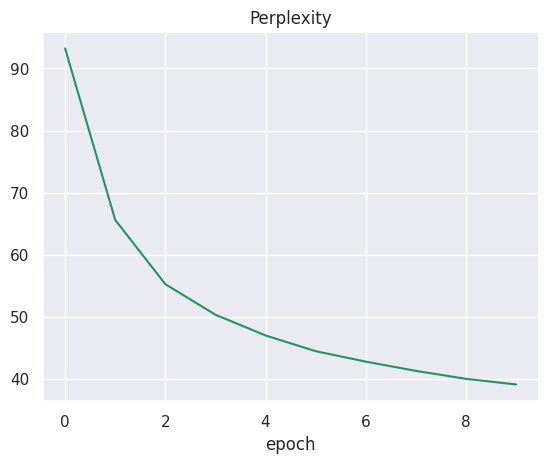

In [ ]:
plt.plot(np.arange(10), qual)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

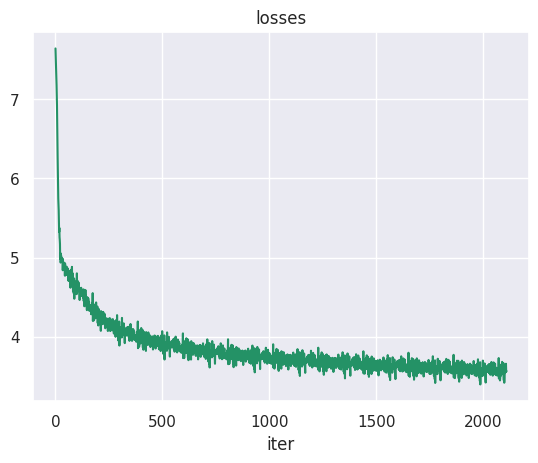

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('losses')
plt.xlabel("iter")
plt.show()

In [ ]:
device = 'cuda'
print(evaluate(model.to(device), criterion, test_dataloader))

  0%|          | 0/132 [00:00<?, ?it/s]

38.75203651370424


#Теперь попробую усложнить сеть. Добавлю два GRU слоя, а также один линейный слой (+дропаут между ними)

In [ ]:
class LanguageModel_MAX(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.gru=nn.GRU(hidden_dim, hidden_dim, num_layers=3, batch_first=True)
        self.linear1=nn.Linear(hidden_dim, hidden_dim)
        self.linear2=nn.Linear(hidden_dim, hidden_dim)
        self.predictor = nn.Linear(hidden_dim, vocab_size)

        self.activate=nn.Tanh()
        self.dropout=nn.Dropout(p=0.3)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        output = self.embed(input_batch)
        output, _ =self.gru(output) #Выход имеет размер [разм батча, кол-во слов в предл, длина эмбединга]
        output = self.linear1(self.activate(output))
        output = self.dropout(output)
        output = self.linear2(self.activate(output))
        output = self.dropout(output)
        output = self.predictor(self.activate(output)) #Выход имеет размер [разм батча, кол-во слов в предл, кол-во слов в словаре.]
        #То есть, на выходе модели мы будем иметь ДЛЯ КАЖДОГО СЛОВА В ПРЕДЛОЖЕНИИ ВЕРОЯТНОСТЬ ПОЛУЧИТЬ СЛЕДУЮЩИМ ОДНО ИЗ СЛОВ СЛОВАРЯ


        return output

In [ ]:
# Обучите модель здесь
model_max = LanguageModel_MAX(vocab_size = len(vocab), hidden_dim=200).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_max.parameters())
qual, losses = train_model(model_max, criterion, optimizer, train_dataloader, eval_dataloader, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

In [ ]:
generate_sequence(model_max, starting_seq=['The', 'actor', 'played', 'badly'])

"<bos> The actor played badly a little too well , and there is no good thing is , I do n't know what they did to do with a little to say , the characters and the characters are not the same , it 's not the reason to get to the end of the movie . <eos>"

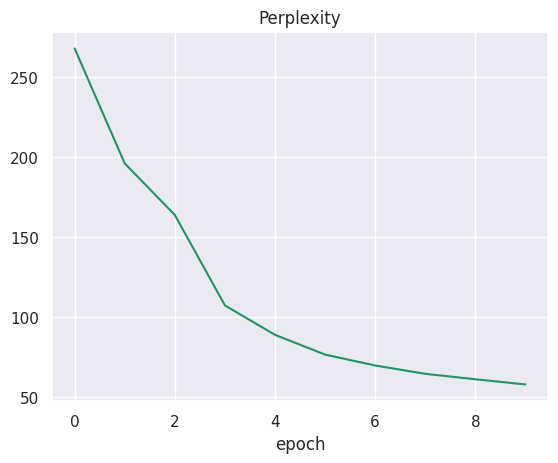

In [ ]:
plt.plot(np.arange(10), qual)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
device = 'cuda'
print(evaluate(model_max.to(device), criterion, test_dataloader))

  0%|          | 0/132 [00:00<?, ?it/s]

57.31477370406642


#Такая модель отработала на порядок хуже. Более сложную модель было бы логично обучать подольше, но не уверен, что это поможет. Возможно, затухают градиенты.

##2-й эесперимент: Увеличу размер скрытого сотояния. Модель возьму исходную, а не с большим количеством слоев.

In [ ]:
# Обучите модель здесь
model_max_500 = LanguageModel(vocab_size = len(vocab), hidden_dim=500).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_max_500.parameters())
qual, losses = train_model(model_max_500, criterion, optimizer, train_dataloader, eval_dataloader, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

In [ ]:
generate_sequence(model_max_500, starting_seq=['The', 'actor', 'played', 'badly'])

"<bos> The actor played badly written by John Ford was directed by John Ford 's `` A The Man '' , `` The Night of the `` The Man '' - that of the first film , and the fact that the movie is also great if the actors are n't , but the script is good , it 's funny it is really bad ... < br / > < br / > The acting is pretty good , and the acting is well done , and it 's funny that I am sure it would be a good idea to be good for a solid film. < br / > < br / > In the end , I could n't stop seeing what it was . <eos>"

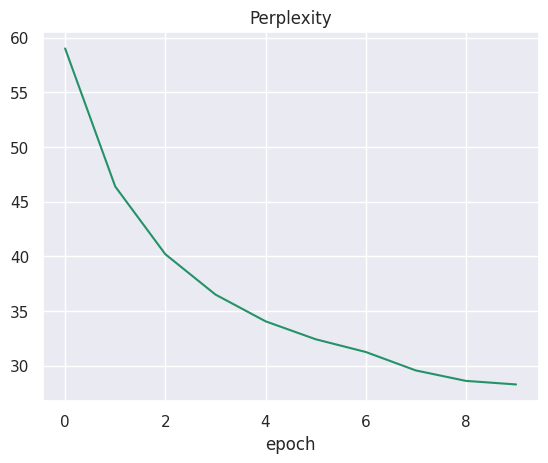

In [ ]:
plt.plot(np.arange(10), qual)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
device = 'cuda'
print(evaluate(model_max_500.to(device), criterion, test_dataloader))

  0%|          | 0/132 [00:00<?, ?it/s]

28.113815061973803


In [ ]:
class LanguageModel_tuned(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        self.gru=nn.GRU(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.linear=nn.Linear(hidden_dim, hidden_dim)
        self.predictor = nn.Linear(hidden_dim, vocab_size)

        self.activate=nn.Tanh()
        self.dropout=nn.Dropout(p=0.2)
        self.norm = nn.LayerNorm(hidden_dim)


    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        output = self.embed(input_batch)
        output, _ =self.gru(output) #Выход имеет размер [разм батча, кол-во слов в предл, длина эмбединга]
        output = self.norm(output)
        output = self.dropout(output)
        output = self.linear(self.activate(output))
        output = self.norm(output)
        output = self.dropout(output)
        output = self.predictor(self.activate(output)) #Выход имеет размер [разм батча, кол-во слов в предл, кол-во слов в словаре.]
        #То есть, на выходе модели мы будем иметь ДЛЯ КАЖДОГО СЛОВА В ПРЕДЛОЖЕНИИ ВЕРОЯТНОСТЬ ПОЛУЧИТЬ СЛЕДУЮЩИМ ОДНО ИЗ СЛОВ СЛОВАРЯ


        return output

In [ ]:
# Обучите модель здесь
model_final = LanguageModel_tuned(vocab_size = len(vocab), hidden_dim=500).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_final.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

qual, losses = train_model(model_final, criterion, optimizer, train_dataloader, eval_dataloader, 20, shed = exp_lr_scheduler)



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

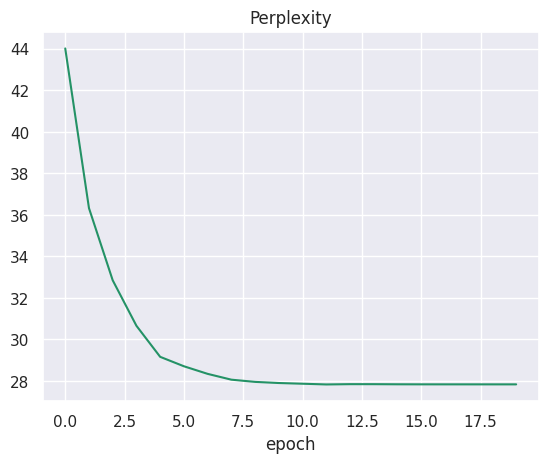

In [ ]:
plt.plot(np.arange(20), qual)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
device = 'cuda'
print(evaluate(model_final.to(device), criterion, test_dataloader))

  0%|          | 0/132 [00:00<?, ?it/s]

27.678695519765217


In [ ]:
generate_sequence(model_final, starting_seq=['The', 'actor', 'played', 'badly'])

"<bos> The actor played badly and not just as much of the movie and it 's not quite as well but the story itself was a very good idea , it would be a good film .. What a movie about the show is about a film that is n't even too much to be taken seriously as well as the viewer that you can be in the movie with the rest of the characters , and that does n't make this film .. <eos>"

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

#Первая базовая модель показала перплексию 38.75. Интерпретировать этот показатель довольно сложно. Если просмотреть на предложения, которые генерирует данная модель, они не лучшего качества. При этом важно отметить, что и сам алгоритм для генерации не самый лучший.
#Первый эксперимент: несколько усложнить модель (увеличить кол-во слоев), провалился. Модель показала качество хуже. Скорее всего, вместе с усложнением модели нужно было добавитьт дропаут, нормализацию, увеличить количество эпох и тогда бы эксперимент был более успешным.
#Так как увеличение глубины модели не дало результата, я попробовал увеличить р-р скрытоего состояния. и такой эксперимент оказался успешным. Перплексия получилась 28.11.
#Последний эксперимент: добавить дропаут, нормалзацию, и корректировку lr во время обучения. И такой эсперимент дал наилучшие результаты. И генерируемые предложения стали более адекватными.

| Базовая модель | Эксперимент 1 | Эксперимент 2 | Эксперимент 3
|-------------|-------------|-------------|-----------
| 38.75   | 57.31    | 28.11    |  27.68
| Перплексия    | Перплексия     | Перплексия     | Перплексия


# Перплексию наверное можно улучшить, если перебрать гиперпараметры, Поварьировать количество слоев, дропауты (веротяность) и другое. Но кажется, что генерировать тексты, которые будут неотличимы от человека, RNN не в состоянии. Потому, чтобы получать лучшее качество, следуюет использовать другой подход.  